In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Bidirectional, TimeDistributed, InputLayer, Embedding, Conv1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

In [0]:
from numpy.random import seed
seed(0)
from tensorflow.random import set_seed
set_seed(0)

Рекуррентные сети могут применяться к разным типам задач. Рассмотрим задачу типа many-to-one. 
Нам даны женские и мужские имена, построим lstm сеть, которая будет предсказывать, женское имя или мужское, извлекая признаки на уровне символов.

(задача взята из https://github.com/divamgupta/lstm-gender-predictor)

In [0]:
from google.colab import files
uploaded = files.upload()

Saving female.txt to female (2).txt
Saving male.txt to male (2).txt


In [0]:
with open("male.txt") as f:
    m_names = f.readlines()

with open("female.txt") as f:
    f_names = f.readlines()

In [0]:
mf_names = []

for f_name in f_names:
	if f_name in m_names:
		mf_names.append(f_name)

m_names = [m_name.lower() for m_name in m_names if not m_name in mf_names]
f_names = [f_name.lower() for f_name in f_names if not f_name in mf_names]


In [0]:
print(f'{len(f_names)} женских имен, {len(m_names)} мужских имен')

4636 женских имен, 2578 мужских имен


In [0]:
f_names[45:57]

['ag\n',
 'agace\n',
 'agata\n',
 'agatha\n',
 'agathe\n',
 'aggi\n',
 'aggie\n',
 'aggy\n',
 'agna\n',
 'agnella\n',
 'agnes\n',
 'agnese\n']

In [0]:
totalEntries = len(m_names) + len(f_names)
maxlen = len(max( m_names , key=len)) + len(max( f_names , key=len))

chars = set(  "".join(m_names) + "".join(f_names))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [0]:
print(f"длина выборки {totalEntries},\nсамое длинное имя {maxlen} символа, \nсимволов в алфавите {len(chars)}")

длина выборки 7214,
самое длинное имя 32 символа, 
символов в алфавите 30


In [0]:
X = np.zeros((totalEntries , maxlen, len(chars) ))#, dtype=np.bool)
y = np.zeros((totalEntries , 2 ))#, dtype=np.bool)


In [0]:
for i, name in enumerate(m_names):
    for t, char in enumerate(name):
        X[i, t, char_indices[char]] = 1
    y[i, 0 ] = 1

for i, name in enumerate(f_names):
    for t, char in enumerate(name):
        X[i + len(m_names), t, char_indices[char]] = 1
    y[i + len(m_names) , 1 ] = 1

In [0]:
X.shape

(7214, 32, 30)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=0)

1. Простая однослойная LSTM сеть

In [0]:
lstm1_model = Sequential()
lstm1_model.add(LSTM(8, input_shape=(maxlen, len(chars))))
lstm1_model.add(Dropout(0.2))
lstm1_model.add(Dense(2))
lstm1_model.add(Activation('softmax'))

In [0]:
lstm1_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
lstm1_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 8)                 1248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 1,266
Trainable params: 1,266
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm1_model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=10)

Epoch 1/10
406/406 [==============================] - 5s 13ms/step - loss: 0.6252 - accuracy: 0.6468 - val_loss: 0.5607 - val_accuracy: 0.6911
Epoch 2/10
406/406 [==============================] - 5s 13ms/step - loss: 0.5649 - accuracy: 0.7221 - val_loss: 0.5502 - val_accuracy: 0.7396
Epoch 3/10
406/406 [==============================] - 5s 12ms/step - loss: 0.5404 - accuracy: 0.7375 - val_loss: 0.5227 - val_accuracy: 0.7645
Epoch 4/10
406/406 [==============================] - 5s 12ms/step - loss: 0.5216 - accuracy: 0.7488 - val_loss: 0.4950 - val_accuracy: 0.7673
Epoch 5/10
406/406 [==============================] - 5s 12ms/step - loss: 0.5072 - accuracy: 0.7609 - val_loss: 0.5050 - val_accuracy: 0.7507
Epoch 6/10
406/406 [==============================] - 5s 12ms/step - loss: 0.4967 - accuracy: 0.7733 - val_loss: 0.4724 - val_accuracy: 0.7881
Epoch 7/10
406/406 [==============================] - 5s 12ms/step - loss: 0.4861 - accuracy: 0.7811 - val_loss: 0.4963 - val_accuracy: 0.7632

In [0]:
def visualize(model):
  plt.plot(model.history.history['accuracy'])
  plt.plot(model.history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

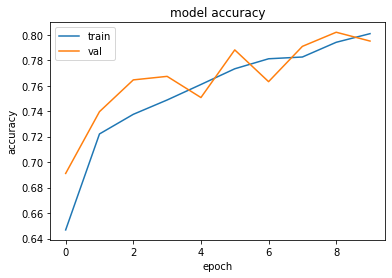

In [0]:
visualize(lstm1_model)

2. Добавим второй LSTM-слой поверх первого

In [0]:
lstm2_model = Sequential()
lstm2_model.add(LSTM(16, return_sequences=True, input_shape=(maxlen, len(chars))))
lstm2_model.add(Dropout(0.2))
lstm2_model.add(LSTM(8, return_sequences=False))
lstm2_model.add(Dropout(0.2))
lstm2_model.add(Dense(2))
lstm2_model.add(Activation('softmax'))

lstm2_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
lstm2_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32, 16)            3008      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 3,826
Trainable params: 3,826
Non-trainable params: 0
____________________________________________________

In [0]:
lstm2_model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=10)

Epoch 1/10
406/406 [==============================] - 10s 25ms/step - loss: 0.6107 - accuracy: 0.6667 - val_loss: 0.5557 - val_accuracy: 0.7479
Epoch 2/10
406/406 [==============================] - 10s 24ms/step - loss: 0.5511 - accuracy: 0.7332 - val_loss: 0.5256 - val_accuracy: 0.7590
Epoch 3/10
406/406 [==============================] - 10s 25ms/step - loss: 0.5191 - accuracy: 0.7566 - val_loss: 0.4877 - val_accuracy: 0.7825
Epoch 4/10
406/406 [==============================] - 10s 24ms/step - loss: 0.4900 - accuracy: 0.7711 - val_loss: 0.4550 - val_accuracy: 0.8006
Epoch 5/10
406/406 [==============================] - 10s 25ms/step - loss: 0.4683 - accuracy: 0.7922 - val_loss: 0.4408 - val_accuracy: 0.8061
Epoch 6/10
406/406 [==============================] - 10s 24ms/step - loss: 0.4561 - accuracy: 0.8011 - val_loss: 0.4349 - val_accuracy: 0.8033
Epoch 7/10
406/406 [==============================] - 10s 25ms/step - loss: 0.4402 - accuracy: 0.8099 - val_loss: 0.4679 - val_accuracy:

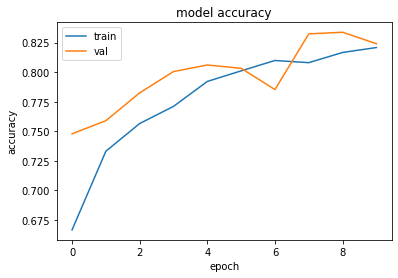

In [0]:
visualize(lstm2_model)

3. Построим двунаправленную LSTM (= biLSTM)


In [0]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(16, return_sequences=False), merge_mode='concat', input_shape=(maxlen, len(chars))))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(2))
bilstm_model.add(Activation('softmax'))

bilstm_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
bilstm_model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 32)                6016      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 6,082
Trainable params: 6,082
Non-trainable params: 0
_________________________________________________________________


In [0]:

bilstm_model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=10)

Epoch 1/10
406/406 [==============================] - 7s 17ms/step - loss: 0.5950 - accuracy: 0.6830 - val_loss: 0.5169 - val_accuracy: 0.7535
Epoch 2/10
406/406 [==============================] - 6s 15ms/step - loss: 0.4886 - accuracy: 0.7691 - val_loss: 0.4660 - val_accuracy: 0.7881
Epoch 3/10
406/406 [==============================] - 6s 16ms/step - loss: 0.4439 - accuracy: 0.8014 - val_loss: 0.4554 - val_accuracy: 0.7978
Epoch 4/10
406/406 [==============================] - 6s 15ms/step - loss: 0.4287 - accuracy: 0.8096 - val_loss: 0.4298 - val_accuracy: 0.8089
Epoch 5/10
406/406 [==============================] - 6s 15ms/step - loss: 0.4175 - accuracy: 0.8127 - val_loss: 0.4231 - val_accuracy: 0.8075
Epoch 6/10
406/406 [==============================] - 6s 15ms/step - loss: 0.4067 - accuracy: 0.8192 - val_loss: 0.4125 - val_accuracy: 0.8199
Epoch 7/10
406/406 [==============================] - 6s 15ms/step - loss: 0.3947 - accuracy: 0.8258 - val_loss: 0.4018 - val_accuracy: 0.8296

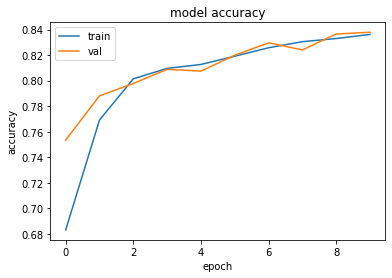

In [0]:
visualize(bilstm_model)

In [1]:
Сравним результаты, полученные сетями на валидационной выборке

SyntaxError: ignored

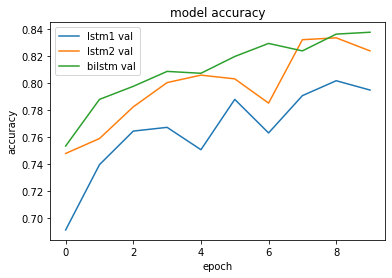

In [0]:


plt.plot(lstm1_model.history.history['val_accuracy'])
plt.plot(lstm2_model.history.history['val_accuracy'])
plt.plot(bilstm_model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['lstm1 val', 'lstm2 val','bilstm val'], loc='upper left')
plt.show()


**POS tagging**

А теперь модифицируем нашу сеть для задачи тэгирования последовательности(many-to-many). На вход сеть будет брать предложение длины n, а на выход отдавать n частеречных тэгов, соответсвующих словам в предложении.   

In [2]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [0]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()

In [0]:
tagged_sentences[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [0]:
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(sentence)
    sentence_tags.append(tags)

In [0]:
sentences[0]

('Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.')

In [0]:
len(sentence_tags)

3914

In [0]:
sent_train, sent_test, tag_train, tag_test = train_test_split(sentences, sentence_tags, test_size=0.2, random_state=0)

In [0]:
vocab = Counter()
for sent in sent_train:
    sent = [word.lower() for word in sent]
    vocab.update(sent)

In [0]:
filtered_vocab = {word for word in vocab if vocab[word] > 5}

In [0]:
len(filtered_vocab)

1674

In [0]:
word2id = {'PAD':0,'UNK':1}    
for i,word in enumerate(filtered_vocab):
      word2id[word] = i + 2

id2word = {i:word for word, i in word2id.items()}

In [0]:
len(id2word)

1676

In [0]:
tag2id = {'PAD':0}  
for tags in tag_train:
    for tag in tags:
      if tag.lower() not in tag2id:
        tag2id[tag.lower()] = len(tag2id)

id2tag = {i:tag for tag, i in tag2id.items()}

In [0]:
len(id2tag)

47

In [0]:
def data2ints(data, smth2id):
  int_data = []
  for seq in data:
      int_seq = []
      for i in seq:
          try:
            int_seq.append(smth2id[i.lower()])
          except KeyError:
            int_seq.append(smth2id['UNK'])
  
      int_data.append(int_seq)
  return int_data
 

In [0]:
X_train_ids, X_test_ids = data2ints(sent_train, word2id), data2ints(sent_test, word2id)
y_train_ids, y_test_ids = data2ints(tag_train, tag2id), data2ints(tag_test, tag2id)


print(X_train_ids[0])
print(X_test_ids[0])
print(y_train_ids[0])
print(y_test_ids[0])

[1041, 1, 312, 1620, 475, 1183, 1, 900, 1, 312, 815, 312, 1360, 429, 194, 1292, 1, 357, 1, 635, 229, 1167, 1, 1620, 454, 312, 156, 1057, 1666, 1042, 1653, 1620, 59, 961, 1588, 1020, 674, 1015, 155, 1287]
[1666, 298, 939, 704, 1390, 1, 321, 155]
[1, 1, 2, 3, 3, 4, 1, 4, 1, 2, 1, 2, 5, 6, 7, 8, 9, 10, 11, 4, 1, 12, 13, 3, 14, 2, 10, 4, 15, 3, 4, 3, 4, 4, 16, 14, 15, 3, 17, 18]
[15, 11, 3, 20, 25, 16, 23, 17]


In [0]:
MAX_LEN = max(len(x) for x in X_train)

In [0]:
X_train, X_test = pad_sequences(X_train_ids, maxlen=MAX_LEN, padding='post'), pad_sequences(X_test_ids, maxlen=MAX_LEN, padding='post')
y_train_pad, y_test_pad = pad_sequences(y_train_ids, maxlen=MAX_LEN, padding='post'), pad_sequences(y_test_ids, maxlen=MAX_LEN, padding='post')

In [0]:
print(X_train.shape, y_train.shape, X_test_pad.shape, y_test_pad.shape)

(3131, 128) (3131, 128) (783, 128) (783, 128)


In [0]:
y_train, y_test = to_categorical(y_train_pad, num_classes=len(tag2id)), to_categorical(y_test_pad, num_classes=len(tag2id))

In [0]:
y_test[6]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
np.argmax(y_test[6], axis=1)

array([11,  3, 14,  9, 22,  4, 15, 11,  3, 12, 13, 24,  4, 16,  3, 19, 16,
        3, 23,  4, 15, 11,  3, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [0]:
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LEN)))
model.add(Embedding(len(word2id),100))
model.add(Bidirectional(LSTM(16, return_sequences=True), merge_mode='concat'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(len(tag2id))))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 100)          167600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 32)           14976     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 128, 47)           1551      
_________________________________________________________________
activation_4 (Activation)    (None, 128, 47)           0         
Total params: 184,127
Trainable params: 184,127
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train,y_train, validation_data=(X_test, y_test), batch_size=128, epochs=10)

Epoch 1/10
25/25 [==============================] - 5s 214ms/step - loss: 0.5280 - accuracy: 0.8736 - val_loss: 0.4963 - val_accuracy: 0.8898
Epoch 2/10
25/25 [==============================] - 5s 184ms/step - loss: 0.4764 - accuracy: 0.8884 - val_loss: 0.4411 - val_accuracy: 0.8963
Epoch 3/10
25/25 [==============================] - 5s 181ms/step - loss: 0.4225 - accuracy: 0.8990 - val_loss: 0.3876 - val_accuracy: 0.9054
Epoch 4/10
25/25 [==============================] - 5s 183ms/step - loss: 0.3718 - accuracy: 0.9090 - val_loss: 0.3391 - val_accuracy: 0.9186
Epoch 5/10
25/25 [==============================] - 5s 191ms/step - loss: 0.3257 - accuracy: 0.9220 - val_loss: 0.2955 - val_accuracy: 0.9324
Epoch 6/10
25/25 [==============================] - 5s 190ms/step - loss: 0.2846 - accuracy: 0.9356 - val_loss: 0.2566 - val_accuracy: 0.9463
Epoch 7/10
25/25 [==============================] - 5s 184ms/step - loss: 0.2481 - accuracy: 0.9474 - val_loss: 0.2230 - val_accuracy: 0.9535
Epoch 

Используем маску для паддингов, так как сеть не должна учитывать их ни при обучении, ни при подсчете метрики.

In [0]:
mask_model = Sequential()
mask_model.add(InputLayer(input_shape=(MAX_LEN)))
mask_model.add(Embedding(len(word2id),100, mask_zero=True))
mask_model.add(Bidirectional(LSTM(256, return_sequences=True)))
mask_model.add(Dropout(0.2))
mask_model.add(Bidirectional(LSTM(128, return_sequences=True)))
mask_model.add(TimeDistributed(Dense(len(tag2id))))
mask_model.add(Activation('softmax'))
mask_model.compile(loss='categorical_crossentropy', optimizer='Adam', 
                   metrics=['accuracy'])
mask_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 128, 100)          167600    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 128, 512)          731136    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128, 512)          0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 128, 256)          656384    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 128, 47)           12079     
_________________________________________________________________
activation_20 (Activation)   (None, 128, 47)           0         
Total params: 1,567,199
Trainable params: 1,567,199
Non-trainable params: 0
___________________________________________

In [0]:
mask_model.fit(X_train,y_train, validation_data=(X_test, y_test), batch_size=128, epochs=20)

Epoch 1/20
25/25 [==============================] - 113s 5s/step - loss: 0.6474 - accuracy: 0.0601 - val_loss: 0.5914 - val_accuracy: 0.0331
Epoch 2/20
25/25 [==============================] - 111s 4s/step - loss: 0.5794 - accuracy: 0.0337 - val_loss: 0.5784 - val_accuracy: 0.0350
Epoch 3/20
25/25 [==============================] - 107s 4s/step - loss: 0.5715 - accuracy: 0.0356 - val_loss: 0.5729 - val_accuracy: 0.0362
Epoch 4/20
25/25 [==============================] - 107s 4s/step - loss: 0.5619 - accuracy: 0.0402 - val_loss: 0.5514 - val_accuracy: 0.0509
Epoch 5/20
25/25 [==============================] - 107s 4s/step - loss: 0.4959 - accuracy: 0.0738 - val_loss: 0.4161 - val_accuracy: 0.0918
Epoch 6/20
25/25 [==============================] - 106s 4s/step - loss: 0.3499 - accuracy: 0.1024 - val_loss: 0.2745 - val_accuracy: 0.1279
Epoch 7/20
25/25 [==============================] - 112s 4s/step - loss: 0.2284 - accuracy: 0.1411 - val_loss: 0.1848 - val_accuracy: 0.1542
Epoch 8/20
25